# An EDA: Handwashing, a weapon against nano-sized foes

**Backstory**: In the 1840s, Dr. Ignaz Semmelweis noticed that there was a significant difference in the mortality rate (due to puerperal fever) between two maternity clinics at the Vienna General Hospital, the hospital where he worked. One of the things that baffled him most was the fact that the fever was rare among women giving street birth. This is weird as a hospital should be a more contained and safer place. His observations led him to believe that this difference was due to cleanliness, which was largely ignored at that time. A full story of this can be read here: <a href='https://en.wikipedia.org/wiki/Ignaz_Semmelweis'>Ignaz Semmelweis</a>. 

**TLDR**: Handwashing is effective!

**Data**: We don't have a ready-made dataset. We will scrape the data ourselves from <a href='https://en.wikipedia.org/wiki/Historical_mortality_rates_of_puerperal_fever'>Historical mortality rates of puerperal fever</a>.

# 1. Getting the data

We will use the `requests` and `bs4` library. The idea is to find our interested table, and put it into a `pandas` DataFrame so that we can do interesting data analysis things with it.

## 1.1. Getting the page

We start off with getting the page of the Wikipedia webpage as a `BeautifulSoup` object.


In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
url = 'https://en.wikipedia.org/wiki/Historical_mortality_rates_of_puerperal_fever'

# create get requests
page = requests.get(url)

# create soup object
soup = BeautifulSoup(page.text, 'lxml')
soup.title

<title>Historical mortality rates of puerperal fever - Wikipedia</title>

## 1.2. Getting the table header and contents

The next step is to find our interested table, get its headers and contents.

In [3]:
# find table
table = soup.find('table', {'class': 'wikitable sortable'})

In [4]:
# getting table headers

table_header = table.find_all('th')

table_header_names = [th.text.strip() for th in table_header]
table_header_names.pop()  # only interested in the first 5 columns

table_header_names

['Year', 'Month', 'Births', 'Deaths', 'Rate (%)']

In [5]:
# getting table contents

# generates a list of <tr> </tr> 
table_content = table.find_all('tr')

# exclude the header row
table_content = table_content[1:]

## 1.3. Turning table rows into `DataFrame` rows

Firstly, we will initialize a dictionary with column names as keys with empty values. Then, we will initialize `len(dict)` empty lists that will be updated as values of each keys in the dictionary. 

In [6]:
# initialize dictionary to pass in columns
table_dict = dict([(name, '') for name in table_header_names])
print(table_dict)

{'Year': '', 'Month': '', 'Births': '', 'Deaths': '', 'Rate (%)': ''}


In [7]:
# initialize empty 'columns' lists
year = []
month = []
births = []
deaths = []
rate = []

def appending_td_to_list(td, lst, index):
    return lst.append(td[index].find(text=True))

for tr in table_content:
    # generates a list of <td> </td>
    td = tr.find_all('td')

    appending_td_to_list(td, year, 0)
    appending_td_to_list(td, month, 1)
    appending_td_to_list(td, births, 2)
    appending_td_to_list(td, deaths, 3)
    appending_td_to_list(td, rate, 4) 

In [8]:
# pass in columns into dictionary
table_dict['Year'] = year
table_dict['Month'] = month
table_dict['Births'] = births
table_dict['Deaths'] = deaths
table_dict['Rate (%)'] = rate

## 1.4. From wiki table into `DataFrame`

Finally, we convert the dictionary into a pandas `DataFrame` object.

In [9]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
# from wiki table to DataFrame
wiki_table = pd.DataFrame(table_dict)

# inspect first 5 elements
wiki_table.sample(5)

,Year,Month,Births,Deaths,Rate (%)
47,\n,December 1844\n,256\n,27\n,10.5\n
46,\n,November 1844\n,245\n,27\n,11.0\n
35,\n,December 1843\n,236\n,19\n,8.1\n
55,\n,August 1845\n,251\n,9\n,3.6\n
43,\n,August 1844\n,269\n,17\n,6.3\n


# 2. Time to clean some data

## 2.1 Hideous `\n` strings

One first obvious thing to do is to remove those hideous `\n`.

In [11]:
# removing '\n' in all columns using str.replace()
for name in table_header_names:
    wiki_table[name] = wiki_table[name].str.replace('\n', '')

wiki_table.sample(5)

,Year,Month,Births,Deaths,Rate (%)
14,,March 1842,264,27,10.2
98,,March 1849,406,20,4.9
5,,June 1841,200,10,5.0
82,,November 1847,246,11,4.5
89,,June 1848,264,3,1.1


## 2.2 To `NaN` or not to `NaN`

After close inspection (read: weird outcomes when applying pandas methods), it turns out that there is a `NaN` value that is not explicitly a `NaN`, that is, an `np.nan`.


In [12]:
# shocking, we don't have any NaN but,
print(wiki_table.isnull().sum())

# we have a NaN that doesn't look like a NaN
nan_but_not_nan = wiki_table[wiki_table.Births.str.match('na')]

# replace 'na' with NaN
lst_name = ['Births', 'Deaths', 'Rate (%)']

for name in lst_name:
    nan_but_not_nan.loc[:, name].replace('na', np.nan, inplace=True)

# taking Set Union of wiki_table and nan_but_not_nan ---> concat + drop_duplicates
wiki_table = pd.concat([wiki_table, nan_but_not_nan], ignore_index=True)
wiki_table.drop_duplicates(subset=['Month'], keep='last', inplace=True)

wiki_table.tail()

Year        0
Month       0
Births      0
Deaths      0
Rate (%)    0
dtype: int64


,Year,Month,Births,Deaths,Rate (%)
95,,December 1848,373,5,1.3
96,1849,January 1849,403,9,2.2
97,,February 1849,389,12,3.1
98,,March 1849,406,20,4.9
99,,December 1841,NaN,NaN,NaN


## 2.3 Filling in this null row, but with two problems

If we fill the `NaN` manually, it will be painful. If use `fillna` with forward or backward fill, then we end up with a mess since it is now the last row. 

Currently, we don't have a natural ordering to sort the column and fill in missing values for `December 1841`. What we can do is to try to convert the `Month` column into `DatetimeIndex`, sort the index and then fill missing values. However, we end up with a different problem below (try uncomment and run that).

In [13]:
# running this returns ValueError: time data 'Mar 1843' does not match format '%B %Y' (match)
# pd.to_datetime(wiki_table.Month, format='%B %Y')

In [14]:
# finding the culprit and removing it
print(wiki_table[wiki_table.Month.str.match('Mar')])

# replace 'Mar 1843' with 'March 1843' to allow us to parse into datetime
wiki_table['Month'] = wiki_table.Month.replace('Mar 1843', 'March 1843', regex=False)

print('\n')

print(wiki_table[wiki_table.Month.str.match('Mar')])

Year       Month Births Deaths Rate (%)
2        March 1841    277     12      4.3
14       March 1842    264     27     10.2
26         Mar 1843    266     33     12.4
38       March 1844    276     47     17.0
50       March 1845    292     13      4.5
62       March 1846    311     48     15.4
74       March 1847    305     11      3.6
86       March 1848    276      0      0.0
98       March 1849    406     20      4.9


   Year       Month Births Deaths Rate (%)
2        March 1841    277     12      4.3
14       March 1842    264     27     10.2
26       March 1843    266     33     12.4
38       March 1844    276     47     17.0
50       March 1845    292     13      4.5
62       March 1846    311     48     15.4
74       March 1847    305     11      3.6
86       March 1848    276      0      0.0
98       March 1849    406     20      4.9


In [15]:
wiki_table['dates'] = pd.to_datetime(wiki_table.Month, format='%B %Y')
wiki_table.dtypes

Year                object
Month               object
Births              object
Deaths              object
Rate (%)            object
dates       datetime64[ns]
dtype: object

In [16]:
# set dates as index
wiki_table.set_index('dates', inplace=True)
wiki_table.sort_index(inplace=True)
wiki_table.head()

,Year,Month,Births,Deaths,Rate (%)
dates,,,,,
1841-01-01,1841,January 1841,254,37,14.6
1841-02-01,,February 1841,239,18,7.5
1841-03-01,,March 1841,277,12,4.3
1841-04-01,,April 1841,255,4,1.6
1841-05-01,,May 1841,255,2,0.8


Great! Let's fill in the single row with `NaN`. Since it is a row sandwiched between non-`NaN` rows, we can just do a forward fill.

In [17]:
# fill NaN using ffill
wiki_table.fillna(method = 'ffill', inplace=True)

# verify that NaN is indeed filled
wiki_table[wiki_table.Month == 'December 1841']

,Year,Month,Births,Deaths,Rate (%)
dates,,,,,
1841-12-01,,December 1841,235,53,22.6


## 2.4 Getting the right Datatypes

We would want `Births`, `Deaths`, and `Rate (%)` in `int` or `float` so that we can use mathematical operations on them.

In [18]:
# inspect
wiki_table.dtypes

Year        object
Month       object
Births      object
Deaths      object
Rate (%)    object
dtype: object

In [19]:
# convert 'Births', 'Deaths' to int type
to_number_cols = ['Births', 'Deaths']
wiki_table[to_number_cols] = wiki_table[to_number_cols].apply(pd.to_numeric, errors='coerce', downcast='signed', axis=1)
wiki_table.dtypes

Year        object
Month       object
Births       int16
Deaths       int16
Rate (%)    object
dtype: object

In [20]:
# convert 'Rate (%)' to float type
wiki_table['Rate (%)'] = wiki_table['Rate (%)'].astype('float', errors='ignore')
wiki_table['Rate (%)'].dtype

dtype('float64')

# 3. A first glance of the data

The fastest way to dive into the data would be to plot it. Let's do some matplotlib magic.

In [21]:
import matplotlib.pyplot as plt

In [22]:
# useful function to plot a timeseries graph
def timeseries_plot(ax, x, y, xlabel = 'some X label', ylabel = 'some Y label', color = 'black', linestyle = 'solid', alpha = 1, color_ticks = True):
    ax.plot(x, y, color, linestyle = linestyle, alpha = alpha)
    ax.set_xlabel(xlabel)
    
    if color_ticks == True:
        ax.set_ylabel(ylabel, color = color)
        ax.tick_params('y', colors = color)
    else:
        ax.set_ylabel(ylabel)

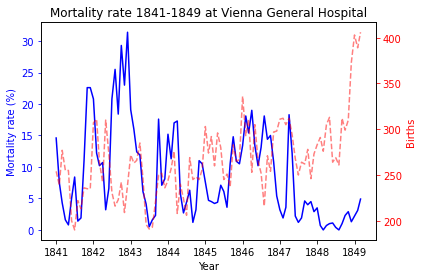

In [23]:
fig, ax = plt.subplots()

# plot rate vs year
timeseries_plot(ax, wiki_table.index, wiki_table['Rate (%)'], 'Year', 'Mortality rate (%)', 'blue')

# plot Births vs year
ax2 = ax.twinx() 
timeseries_plot(ax2, wiki_table.index, wiki_table.Births, 'Year', 'Births', 'red', linestyle = '--', alpha = 0.5)

ax.set_title('Mortality rate 1841-1849 at Vienna General Hospital')

plt.show()

There is a significant trajectory change post-1847. There must be something going on here. It turns out, that was when handwashing was introduced!

# 4. What happened before and after handwashing?

To make the data more visually clear, let us separate the years before and after handwashing was introduced. Based on the Wikipedia page, a 'Handwashing policy' is 'instituted mid-May' on 1847. We will focus on this date.

In [24]:
from datetime import datetime, timedelta
instituted_date = datetime.strptime('May 1847', '%B %Y').date()
effective_impact_date = datetime.strptime('June 1847', '%B %Y').date()
strict_control = datetime.strptime('January 1848', '%B %Y').date()

start_handwashing = wiki_table.loc[effective_impact_date]
pre_handwashing = wiki_table.loc[:effective_impact_date]
post_handwashing = wiki_table.loc[effective_impact_date:]

In [25]:
def get_rate_and_births(month):
    row = wiki_table[wiki_table.Month == month]
    rate = row.values[0][-1]
    births = row.values[0][2]

    return rate, births

# get Rate (%) and Births on instituted_date: May 1847
rate_instituted_date, births_instituted_date = get_rate_and_births('May 1847')

# get Rate (%) and Births on strict_control: January 1848
rate_strict_control, births_strict_control = get_rate_and_births('January 1848')

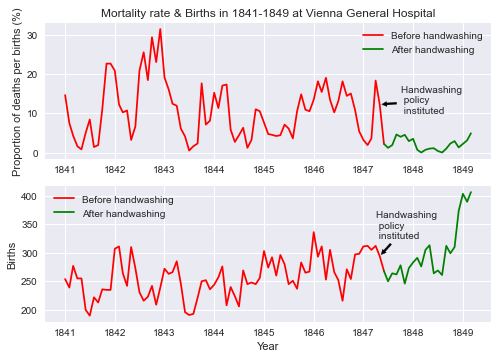

In [26]:
plt.style.use('seaborn')

fig, ax2 = plt.subplots(2, 1)

# plot Rate (%) before and after handwashing
ax2[0].plot(pre_handwashing.index, pre_handwashing['Rate (%)'], label = 'Before handwashing', color = 'red')
ax2[0].plot(post_handwashing.index, post_handwashing['Rate (%)'], label = 'After handwashing', color = 'green')

# plot Births before and after handwashing
ax2[1].plot(pre_handwashing.index, pre_handwashing.Births, label = 'Before handwashing', color = 'red')
ax2[1].plot(post_handwashing.index, post_handwashing.Births, label = 'After handwashing', color = 'green')

# set labels
ax2[0].set_ylabel('Proportion of deaths per births (%)')
ax2[1].set_ylabel('Births')
ax2[1].set_xlabel('Year')

# set title
ax2[0].set_title('Mortality rate & Births in 1841-1849 at Vienna General Hospital')

# annotate both plots
ax2[0].annotate('Handwashing \n policy \n instituted', 
             xy = (instituted_date, rate_instituted_date),
             xytext = (pd.to_datetime('1847-10-01'), 10),
             arrowprops = {'arrowstyle':'simple', 'color':'k'})

ax2[1].annotate('Handwashing \n policy \n instituted', 
             xy = (instituted_date, births_instituted_date),
             xytext = (pd.to_datetime('1847-4-01'), 325),
             arrowprops = {'arrowstyle':'simple', 'color':'k'})             

# set legend
ax2[0].legend()
ax2[1].legend()

plt.show()

# 5. Quantitative value for the change

How effective was handwashing quantitatively? Let's calculate the difference between the mean of mortality rate pre-handwashing and the mean of mortality rate post-handwashing.

In [27]:
pre_rate = pre_handwashing['Rate (%)']
post_rate = post_handwashing['Rate (%)']

diff_in_mean = post_rate.mean() - pre_rate.mean()
diff_in_std = post_rate.std() - pre_rate.std()

print(f'Mean of mortality rate pre-handwashing: {round(pre_rate.mean(), 2)}%')
print(f'Mean of mortality rate post-handwashing: {round(post_rate.mean(), 2)}%')
print(f'Difference in mean: {round(diff_in_mean, 2)}%')

print('\n')

print(f'Standard error of mortality rate pre-handwashing: {round(pre_rate.std(), 2)}%')
print(f'Standard error of mortality rate post-handwashing: {round(post_rate.std(), 2)}%')
print(f'Difference in standard error: {round(diff_in_std, 2)}%')

Mean of mortality rate pre-handwashing: 10.55%
Mean of mortality rate post-handwashing: 2.11%
Difference in mean: -8.44%


Standard error of mortality rate pre-handwashing: 7.18%
Standard error of mortality rate post-handwashing: 1.52%
Difference in standard error: -5.66%


Our research shows that there is a stunning -8.44% drop in mean of mortality rate after handwashing was introduced! Furthermore, there is a significant -5.66% drop in standard error of mortality rate post-handwashing. The standard error of mortality rate post-handwashing is merely a 1.52% which shows that the data does not deviate far off from the mean. This is definitely a good sign!

# 6. Confidence intervals for the population mean & standard deviation

We will use the bootstrap method to generate a 90% confidence interval for the population mean of difference in mortality rate between pre and post handwashing.





In [28]:
def func_diff_bootstrap_replicate(pre_series, post_series, func):
    '''Generates bootstrap replicate of the difference in func applied to two pre-post pandas Series'''
    pre_replicate =  pre_series.sample(frac=1, replace=True)
    post_replicate = post_series.sample(frac=1, replace=True)
    func_diff = func(post_replicate) - func(pre_replicate)
    return func_diff

def conf_int(lst, conf=90, result='series'):
    '''Computes the confidence interval from a list and returns a pandas Series or a numpy array'''
    if result == 'series':
        if conf == 90:
            return pd.Series(lst).quantile([0.05, 0.95])
        elif conf == 95:
            return pd.Series(lst).quantile([0.025, 0.975])
        elif conf == 97.5:
            return pd.Series(lst).quantile([0.0125, 0.9875])
        elif conf == 99:
            return pd.Series(lst).quantile([0.005, 0.995])

    if result == 'array':
        if conf == 90:
            return np.percentile(lst, [5, 95])
        elif conf == 95:
            return np.percentile(lst, [2.5, 97.5])
        elif conf == 97.5:
            return np.percentile(lst, [1.25, 98.75])
        elif conf == 99:
            return np.percentile(lst, [0.5, 99.5])

In [29]:
bs_replicates = []

for i in range(2000):
    mean_diff = func_diff_bootstrap_replicate(pre_rate, post_rate, np.mean)
    bs_replicates.append(mean_diff)

conf_interval = conf_int(bs_replicates, conf=90, result='series')
conf_interval

0.05   -9.895851
0.95   -7.106171
dtype: float64

In [30]:
bs_replicates_2 = []

for i in range(2000):
    std_diff = func_diff_bootstrap_replicate(pre_rate, post_rate, np.std)
    bs_replicates_2.append(std_diff)

conf_interval = conf_int(bs_replicates_2, conf=90, result='series')
conf_interval

0.05   -6.604073
0.95   -4.680832
dtype: float64

Based on a 90% confidence interval, we can conclude that the true population mean in difference lies between approximately -9.9 and -7 percent. In layman terms, this means that Semmelweis' proposal for handwashing was able to reduce mortality rates by a value somewhere between 7 and 9.9 percent, if this observation is done on a very large scale.

We can also expect, based on a 90% confidence interval, that the true population standard deviation in difference lies between -6.6 and -4.5 percent. Without doubt, this is quite huge considering our statistic is the standard deviation here. This reflects how significant handwashing was.

# 6. Zero percent mortality rate

There is another important date, January 1848, where the event 'strict controls enforced on students negligent hand-wash' happened. We will zoom in into `post_handwashing` and see how this event affected the mortality rate.

In [31]:
effective_control_date = strict_control + timedelta(days=31)

pre_control = post_handwashing[:effective_control_date]
post_control = post_handwashing[effective_control_date:]

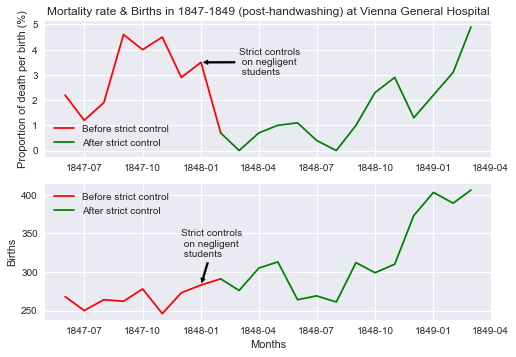

In [32]:
fig, ax3 = plt.subplots(2, 1)

ax3[0].plot(pre_control.index, pre_control['Rate (%)'], color = 'red', label='Before strict control')
ax3[0].plot(post_control.index, post_control['Rate (%)'], color = 'green', label='After strict control')

ax3[1].plot(pre_control.index, pre_control['Births'], color = 'red', label='Before strict control')
ax3[1].plot(post_control.index, post_control['Births'], color = 'green', label='After strict control')

# set labels
ax3[0].set_title('Mortality rate & Births in 1847-1849 (post-handwashing) at Vienna General Hospital')
ax3[0].set_ylabel('Proportion of death per birth (%)')
ax3[1].set_ylabel('Births')
ax3[1].set_xlabel('Months')

ax3[0].annotate('Strict controls \n on negligent \n students', 
             xy = (strict_control, rate_strict_control),
             xytext = (pd.to_datetime('1848-03-01'), 3),
             arrowprops = {'arrowstyle':'simple', 'color':'k'})

ax3[1].annotate('Strict controls \n on negligent \n students', 
             xy = (strict_control, births_strict_control),
             xytext = (pd.to_datetime('1847-12-01'), 320),
             arrowprops = {'arrowstyle':'simple', 'color':'k'})             

ax3[0].legend()
ax3[1].legend()
plt.show()

Notice how after the strict control was imposed, the mortality rate plunged to zero! In fact, there were two dates for which the mortality rate was absolutely zero percent. There was no immediate reaction on the chart for Births against Months. However, we can see that the number of Births increased drastically in subsequent months, showing confidence of people in the clinic.

In [33]:
zero_rate = post_handwashing[post_handwashing['Rate (%)'] == 0]
print(zero_rate)

Year        Month  Births  Deaths  Rate (%)
dates                                                 
1848-03-01        March 1848     276       0       0.0
1848-08-01       August 1848     261       0       0.0
